In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import glob
import re
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib
from tqdm import tqdm

2025-05-19 14:09:19.965235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 14:09:19.966248: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 14:09:19.970191: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 14:09:19.982196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747678160.002209  160033 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747678160.00

In [2]:
#shape of VAE is 38, 100, 100, 2, 100, 100 38

In [3]:
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['legend.fontsize'] = 13

Data preprocessing (same step for all methods):

In [4]:
data = pd.read_csv('../tsne_umap_tutorials/data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')

# data = pd.read_csv('APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')

In [5]:
# Spatial:
ra = data["RA"]   #APOGEE
dec = data["DEC"]   #APOGEE

# Identification:
apogee_ID = data["# APOGEE_ID_"]   #APOGEE
gaia_ID = data["GAIAEDR3_SOURCE_ID"]  # Gaia

# Kinematic:
parallax = data["GAIAEDR3_PARALLAX"]  # Gaia
pmra = data["GAIAEDR3_PMRA"]  # Gaia
pmra_err = data["GAIAEDR3_PMRA_ERROR"]  # Gaia
pmdec = data["GAIAEDR3_PMDEC"]  # Gaia
pmdec_err = data["GAIAEDR3_PMDEC_ERROR"]  # Gaia
RV = data["VHELIO_AVG"]   #APOGEE
RV_err = data["VERR"]   #APOGEE
#dist = data["dist"]   #APOGEE no dist in this dataset?
#dist_err = data["dist_err"]   #APOGEE
jr = data["jr"]   #APOGEE
jr_err = data["jr_err"]   #APOGEE
jz = data["jz"]   #APOGEE
jz_err = data["jz_err"]   #APOGEE
#jphi = data["jphi"]   #APOGEE no jphi in this dataset?
#jphi_err = data["jphi_err"]    #APOGEE

# # Spectral (useful for filtering):
TEFF_ERR = data["TEFF_ERR"]   #APOGEE
TEFF = data["TEFF"]   #APOGEE
LOGG_ERR = data["LOGG_ERR"]   #APOGEE
LOGG = data["LOGG"]   #APOGEE
SNR = data["SNR"]   #APOGEE
ASPCAPFLAG = data["ASPCAPFLAG"]
STARFLAG = data["STARFLAG"]

# # Chemical abundances from astroNN:
FE_H = data['FE_H'] 
C_FE = data['C_FE']
CI_FE = data['CI_FE']
N_FE = data['N_FE']
O_FE = data['O_FE']
MG_FE = data['MG_FE']
AL_FE = data['AL_FE']
SI_FE = data['SI_FE']
P_FE = data['P_FE']
S_FE = data['S_FE']
K_FE = data['K_FE']
CA_FE = data['CA_FE']
TI_FE = data['TI_FE']
TIII_FE = data['TIII_FE']
V_FE = data['V_FE']
CR_FE = data['CR_FE']
MN_FE = data['MN_FE']
CO_FE = data['CO_FE']
NI_FE = data['NI_FE']

# # Chemical abundance errors from astroNN:
FE_H_err = data["FE_H_ERR"] 
C_FE_err = data['C_FE_ERR']
CI_FE_err = data['CI_FE_ERR']
N_FE_err = data['N_FE_ERR']
O_FE_err = data['O_FE_ERR']
MG_FE_err = data['MG_FE_ERR']
AL_FE_err = data['AL_FE_ERR']
SI_FE_err = data['SI_FE_ERR']
P_FE_err = data['P_FE_ERR']
S_FE_err = data['S_FE_ERR']
K_FE_err = data['K_FE_ERR']
CA_FE_err = data['CA_FE_ERR']
TI_FE_err = data['TI_FE_ERR']
TIII_FE_err = data['TIII_FE_ERR']
V_FE_err = data['V_FE_ERR']
CR_FE_err = data['CR_FE_ERR']
MN_FE_err = data['MN_FE_ERR']
CO_FE_err = data['CO_FE_ERR']
NI_FE_err = data['NI_FE_ERR']

# # Number of stars in the initial sample of APOGEE DR16: 
print("There are {} stars in our initial sample".format(len(ra)))

cols = [ra, dec, apogee_ID, gaia_ID, parallax, pmra, pmra_err, pmdec, pmdec_err, RV, RV_err, #dist, dist_err,
         jr, jr_err,# jphi, jphi_err,
        jz, jz_err, TEFF, TEFF_ERR, LOGG, LOGG_ERR, SNR, ASPCAPFLAG, STARFLAG, FE_H, FE_H_err, C_FE, 
         C_FE_err, CI_FE, CI_FE_err, N_FE, N_FE_err, O_FE, O_FE_err, MG_FE, MG_FE_err, AL_FE, AL_FE_err, SI_FE,
         SI_FE_err, P_FE, P_FE_err, S_FE, S_FE_err, K_FE, K_FE_err, CA_FE, CA_FE_err, TI_FE, TI_FE_err, TIII_FE,
         TIII_FE_err, V_FE, V_FE_err, CR_FE, CR_FE_err, MN_FE, MN_FE_err, CO_FE, CO_FE_err, NI_FE, NI_FE_err]

There are 370060 stars in our initial sample


In [6]:
aspcapflags_filter = np.array(cols[20])==0
starflags_filter = np.array(cols[21])==0

filters = aspcapflags_filter*starflags_filter


filtered_data = []
for c in cols:
    a = np.array(c)[filters]
    filtered_data.append(a)
    
print("There are {} stars in our filtered sample".format(len(filtered_data[0])))

There are 144767 stars in our filtered sample


In [7]:
FE_H_filtered, C_FE_filtered, CI_FE_filtered = filtered_data[22], filtered_data[24], filtered_data[26]
N_FE_filtered, O_FE_filtered, MG_FE_filtered = filtered_data[28], filtered_data[30], filtered_data[32]
AL_FE_filtered, SI_FE_filtered, P_FE_filtered = filtered_data[34], filtered_data[36], filtered_data[38]
S_FE_filtered, K_FE_filtered, CA_FE_filtered = filtered_data[40], filtered_data[42], filtered_data[44]
TI_FE_filtered, TIII_FE_filtered, V_FE_filtered = filtered_data[46], filtered_data[48], filtered_data[50]
CR_FE_filtered, MN_FE_filtered, CO_FE_filtered, NI_FE_filtered = filtered_data[52], filtered_data[54], filtered_data[56], filtered_data[58]
RV_filtered  = filtered_data[9]

In [8]:
FE_H_err, C_FE_err, CI_FE_err = filtered_data[23], filtered_data[25], filtered_data[27]
N_FE_err, O_FE_err, MG_FE_err = filtered_data[29], filtered_data[31], filtered_data[33]
AL_FE_err, SI_FE_err, P_FE_err = filtered_data[35], filtered_data[37], filtered_data[39]
S_FE_err, K_FE_err, CA_FE_err = filtered_data[41], filtered_data[43], filtered_data[45]
TI_FE_err, TIII_FE_err, V_FE_err = filtered_data[47], filtered_data[49], filtered_data[51]
CR_FE_err, MN_FE_err, CO_FE_err, NI_FE_err = filtered_data[53], filtered_data[55], filtered_data[57], filtered_data[59]
RV_err  = filtered_data[10]

In [9]:
train_size = round(0.8 * len(filtered_data[0]))
test_size = round(0.1 * len(filtered_data[0]))
validation_size = round(0.1 * len(filtered_data[0]))

training_labels_raw = np.transpose(np.array([FE_H_filtered[:train_size], C_FE_filtered[:train_size], CI_FE_filtered[:train_size], 
                                        N_FE_filtered[:train_size], O_FE_filtered[:train_size], MG_FE_filtered[:train_size],
                                        AL_FE_filtered[:train_size], SI_FE_filtered[:train_size], P_FE_filtered[:train_size],
                                        S_FE_filtered[:train_size], K_FE_filtered[:train_size], CA_FE_filtered[:train_size],
                                        TI_FE_filtered[:train_size], TIII_FE_filtered[:train_size], V_FE_filtered[:train_size], 
                                        CR_FE_filtered[:train_size], MN_FE_filtered[:train_size], CO_FE_filtered[:train_size], NI_FE_filtered[:train_size]]))

error_training_labels_raw = np.transpose(np.array([FE_H_err[:train_size], C_FE_err[:train_size], CI_FE_err[:train_size], 
                                        N_FE_err[:train_size], O_FE_err[:train_size], MG_FE_err[:train_size],
                                        AL_FE_err[:train_size], SI_FE_err[:train_size], P_FE_err[:train_size],
                                        S_FE_err[:train_size], K_FE_err[:train_size], CA_FE_err[:train_size],
                                        TI_FE_err[:train_size], TIII_FE_err[:train_size], V_FE_err[:train_size], 
                                        CR_FE_err[:train_size], MN_FE_err[:train_size], CO_FE_err[:train_size], NI_FE_err[:train_size]]))


test_labels_raw = np.transpose(np.array([FE_H_filtered[train_size: train_size + test_size], C_FE_filtered[train_size: train_size + test_size], 
                                     CI_FE_filtered[train_size: train_size + test_size], N_FE_filtered[train_size: train_size + test_size],
                                     O_FE_filtered[train_size: train_size + test_size], MG_FE_filtered[train_size: train_size + test_size],
                                        AL_FE_filtered[train_size: train_size + test_size], SI_FE_filtered[train_size: train_size + test_size], 
                                     P_FE_filtered[train_size: train_size + test_size], S_FE_filtered[train_size: train_size + test_size], 
                                     K_FE_filtered[train_size: train_size + test_size], CA_FE_filtered[train_size: train_size + test_size],
                                        TI_FE_filtered[train_size: train_size + test_size], TIII_FE_filtered[train_size: train_size + test_size], 
                                     V_FE_filtered[train_size: train_size + test_size], CR_FE_filtered[train_size: train_size + test_size], 
                                     MN_FE_filtered[train_size: train_size + test_size], CO_FE_filtered[train_size: train_size + test_size], 
                                     NI_FE_filtered[train_size: train_size + test_size]]))
                                     
                                     
error_test_labels_raw = np.transpose(np.array([FE_H_err[train_size: train_size + test_size], C_FE_err[train_size: train_size + test_size], CI_FE_err[train_size: train_size + test_size], 
                                        N_FE_err[train_size: train_size + test_size], O_FE_err[train_size: train_size + test_size], MG_FE_err[train_size: train_size + test_size],
                                        AL_FE_err[train_size: train_size + test_size], SI_FE_err[train_size: train_size + test_size], P_FE_err[train_size: train_size + test_size],
                                        S_FE_err[train_size: train_size + test_size], K_FE_err[train_size: train_size + test_size], CA_FE_err[train_size: train_size + test_size],
                                        TI_FE_err[train_size: train_size + test_size], TIII_FE_err[train_size: train_size + test_size], V_FE_err[train_size: train_size + test_size], 
                                        CR_FE_err[train_size: train_size + test_size], MN_FE_err[train_size: train_size + test_size], CO_FE_err[train_size: train_size + test_size], NI_FE_err[train_size: train_size + test_size]]))


validation_labels_raw = np.transpose(np.array([FE_H_filtered[train_size + test_size: train_size + test_size + validation_size], C_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     CI_FE_filtered[train_size + test_size: train_size + test_size + validation_size], N_FE_filtered[train_size + test_size: train_size + test_size + validation_size],
                                     O_FE_filtered[train_size + test_size: train_size + test_size + validation_size], MG_FE_filtered[train_size + test_size: train_size + test_size + validation_size],
                                        AL_FE_filtered[train_size + test_size: train_size + test_size + validation_size], SI_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     P_FE_filtered[train_size + test_size: train_size + test_size + validation_size], S_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     K_FE_filtered[train_size + test_size: train_size + test_size + validation_size], CA_FE_filtered[train_size + test_size: train_size + test_size + validation_size],
                                        TI_FE_filtered[train_size + test_size: train_size + test_size + validation_size], TIII_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     V_FE_filtered[train_size + test_size: train_size + test_size + validation_size], CR_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     MN_FE_filtered[train_size + test_size: train_size + test_size + validation_size], CO_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     NI_FE_filtered[train_size + test_size: train_size + test_size + validation_size]]))
                                     
                                     
error_validation_labels_raw = np.transpose(np.array([FE_H_err[train_size + test_size: train_size + test_size + validation_size], C_FE_err[train_size + test_size: train_size + test_size + validation_size], CI_FE_err[train_size + test_size: train_size + test_size + validation_size], 
                                        N_FE_err[train_size + test_size: train_size + test_size + validation_size], O_FE_err[train_size + test_size: train_size + test_size + validation_size], MG_FE_err[train_size + test_size: train_size + test_size + validation_size],
                                        AL_FE_err[train_size + test_size: train_size + test_size + validation_size], SI_FE_err[train_size + test_size: train_size + test_size + validation_size], P_FE_err[train_size + test_size: train_size + test_size + validation_size],
                                        S_FE_err[train_size + test_size: train_size + test_size + validation_size], K_FE_err[train_size + test_size: train_size + test_size + validation_size], CA_FE_err[train_size + test_size: train_size + test_size + validation_size],
                                        TI_FE_err[train_size + test_size: train_size + test_size + validation_size], TIII_FE_err[train_size + test_size: train_size + test_size + validation_size], V_FE_err[train_size + test_size: train_size + test_size + validation_size], 
                                        CR_FE_err[train_size + test_size: train_size + test_size + validation_size], MN_FE_err[train_size + test_size: train_size + test_size + validation_size], CO_FE_err[train_size + test_size: train_size + test_size + validation_size], NI_FE_err[train_size + test_size: train_size + test_size + validation_size]]))


In [10]:
full_training_labels_raw = np.c_[training_labels_raw, error_training_labels_raw]
full_test_labels_raw = np.c_[test_labels_raw, error_test_labels_raw]
full_validation_labels_raw = np.c_[validation_labels_raw, error_validation_labels_raw]

In [11]:
full_training_labels_raw.shape, full_test_labels_raw.shape, full_validation_labels_raw.shape

((115814, 38), (14477, 38), (14476, 38))

In [12]:
np.min(full_training_labels_raw.T, axis=1), np.max(full_training_labels_raw.T, axis=1)

(array([-1.951497  , -2.1234312 , -2.119044  , -0.18978369, -0.7124527 ,
        -0.15558027, -0.47890055, -0.15707995, -0.97891414, -0.6047195 ,
        -2.2741165 , -0.40278423, -1.2907453 , -0.6157368 , -1.1658391 ,
        -1.391077  , -0.64225805, -3.6896837 , -0.2965148 ,  0.01358107,
         0.01762647,  0.02378747,  0.01708818,  0.01984493,  0.02071843,
         0.02232191,  0.01871411,  0.05818468,  0.01897749,  0.03516773,
         0.02518716,  0.02486172,  0.02255343,  0.0375476 ,  0.02254345,
         0.02762588,  0.01909786,  0.02221127]),
 array([5.7460123e-01, 8.3517190e-01, 5.6674075e-01, 3.6616602e+00,
        5.5585840e-01, 5.1025960e-01, 4.8934165e-01, 4.5210746e-01,
        7.5247210e+00, 9.0582700e-01, 1.0242985e+00, 2.7282690e-01,
        5.9501344e-01, 8.7636330e-01, 8.6697330e-01, 3.3210137e-01,
        3.5304812e-01, 5.6587050e-01, 2.1270613e-01, 4.5790780e-01,
        1.2761971e+00, 1.6784387e+00, 1.8850280e+01, 5.6260234e-01,
        5.5715760e-01, 6.7058295

In [13]:
err_threshold = 3 # remove errors that are larger than this...
err_mask_train = np.all(np.abs(full_training_labels_raw) < err_threshold, axis=1)
err_mask_test = np.all(np.abs(full_test_labels_raw) < err_threshold, axis=1)
err_mask_validation = np.all(np.abs(full_validation_labels_raw) < err_threshold, axis=1)

Remove unreasonably huge errors bars or unphysical abundance estimates:

In [14]:
full_training_labels = full_training_labels_raw[err_mask_train]
full_test_labels = full_test_labels_raw[err_mask_test]
full_validation_labels = full_validation_labels_raw[err_mask_validation]

In [15]:
full_training_labels.shape, full_test_labels.shape, full_validation_labels.shape

((114885, 38), (14374, 38), (14326, 38))

In [16]:
np.min(full_training_labels.T, axis=1), np.max(full_training_labels.T, axis=1)

(array([-1.8320073 , -1.2602895 , -2.119044  , -0.18978369, -0.7124527 ,
        -0.1388877 , -0.47890055, -0.13207644, -0.97891414, -0.5242982 ,
        -0.7713039 , -0.40278423, -1.2907453 , -0.6157368 , -1.1658391 ,
        -1.0536897 , -0.64225805, -1.1330373 , -0.2965148 ,  0.01358107,
         0.01762647,  0.02378747,  0.01708818,  0.01984493,  0.02071843,
         0.02232191,  0.01871411,  0.05818468,  0.01897749,  0.03516773,
         0.02518716,  0.02486172,  0.02255343,  0.0375476 ,  0.02254345,
         0.02762588,  0.01909786,  0.02221127]),
 array([0.57460123, 0.81556314, 0.56674075, 1.5901425 , 0.5558584 ,
        0.5102596 , 0.48934165, 0.45210746, 1.0318542 , 0.905827  ,
        1.0242985 , 0.262527  , 0.59501344, 0.8763633 , 0.8669733 ,
        0.27449507, 0.35304812, 0.5658705 , 0.21270613, 0.35667247,
        0.48992783, 1.637775  , 1.0633858 , 0.46304193, 0.43964195,
        0.55135024, 0.46292186, 2.998515  , 0.55373484, 2.87389   ,
        1.0069572 , 0.7626475 , 

In [17]:
from sklearn.preprocessing import StandardScaler

Manual scaler to standardize (equivalent to StandardScaler):

In [18]:
# standardized_pca_array = []
# standardization_means = np.zeros(len(np.array(x_df_transpose)))
# standardization_sigmas = np.zeros(len(np.array(x_df_transpose)))

# for i, param in enumerate(np.array(x_df_transpose)):
#     mean, sigma = np.mean(param), np.std(param)
#     norm = (param - mean)/sigma
#     standardized_pca_array.append(norm)
#     standardization_means[i] = mean
#     standardization_sigmas[i] = sigma

StandardScaler to standardize (same method for t-SNE/UMAP):

In [19]:
from sklearn.preprocessing import StandardScaler

# split abundances and errors into separate datasets
training_labels_abundances = full_training_labels[:, :19]
training_labels_errors = full_training_labels[:, 19:]

test_labels_abundances = full_test_labels[:, :19]
test_labels_errors = full_test_labels[:, 19:]

validation_labels_abundances = full_validation_labels[:, :19]
validation_labels_errors = full_validation_labels[:, 19:]

# standardize means fitting and transforming with standard scaler, standardize errors by scaling by the scale factor (mean will shift but this does not change the errors)
training_scaler = StandardScaler().fit(training_labels_abundances)
standardized_abundance_training_arr = training_scaler.transform(training_labels_abundances)
standardized_error_training_arr = training_labels_errors/training_scaler.scale_
standardized_full_training_arr = np.c_[standardized_abundance_training_arr, standardized_error_training_arr]

test_scaler = StandardScaler().fit(test_labels_abundances)
standardized_abundance_test_arr = test_scaler.transform(test_labels_abundances)
standardized_error_test_arr = test_labels_errors/test_scaler.scale_
standardized_full_test_arr = np.c_[standardized_abundance_test_arr, standardized_error_test_arr]

validation_scaler = StandardScaler().fit(validation_labels_abundances)
standardized_abundance_validation_arr = validation_scaler.transform(validation_labels_abundances)
standardized_error_validation_arr = validation_labels_errors/validation_scaler.scale_
standardized_full_validation_arr = np.c_[standardized_abundance_validation_arr, standardized_error_validation_arr]

VAE stuff:

Classes used in VAEs:

In [20]:
class Sampling(layers.Layer):
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

class mu_var(tf.keras.Layer):
    def call(self, x_mu, x_log_var):
        return tf.concat([x_mu, x_log_var], 1)

## Load all methods:

PCA:

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

n_params = len(training_labels_abundances.T)
# perform PCA
pca = PCA(n_components = 2)
# fit the pca using the training array
fit_pca = pca.fit(standardized_abundance_training_arr)

# transform the training array
train_pca = fit_pca.transform(standardized_abundance_training_arr)
reconstructed_abundance_training_arr = fit_pca.inverse_transform(train_pca)
# transform the test array
test_pca = fit_pca.transform(standardized_abundance_test_arr)
reconstructed_abundance_test_arr = fit_pca.inverse_transform(test_pca)
# compute MSE
pca_training_mse = np.mean(np.mean((standardized_abundance_training_arr - reconstructed_abundance_training_arr) ** 2, axis=-1)) * 1000
pca_test_mse = np.mean(np.mean((standardized_abundance_test_arr - reconstructed_abundance_test_arr) ** 2, axis=-1)) * 1000
pca_training_chi2 = np.mean(np.mean(((standardized_abundance_training_arr - 
                                      reconstructed_abundance_training_arr) ** 2)/(2 * standardized_error_training_arr ** 2), axis=-1)) * 1000
pca_test_chi2 = np.mean(np.mean(((standardized_abundance_test_arr - 
                                  reconstructed_abundance_test_arr) ** 2)/(2 * standardized_error_test_arr ** 2), axis=-1)) * 1000

In [22]:
pca_training_mse, pca_test_mse, pca_training_chi2, pca_test_chi2

(281.63877014335577, 274.1159919198752, 693.2386013784889, 733.8453479247756)

UMAP:

In [23]:
umap_training_mses = np.load('./umap_training_epochs_mses.npy')
umap_test_mses = np.load('./umap_test_epochs_mses.npy')
umap_training_chi2s = np.load('./umap_training_epochs_chi2s.npy')
umap_test_chi2s = np.load('./umap_test_epochs_chi2s.npy')

In [24]:
# Path to the folder containing the files
folder_path = './umap_models/'

# Pattern to match files
pattern = os.path.join(folder_path, 'decoder_*.pkl')
file_paths = glob.glob(pattern)

# Dictionary to hold data and their corresponding numbers
val_mses = []
val_chi2s = []

for path in file_paths:
    # Extract number using regex
    match = re.search(r'decoder_umap_(\d+)\.pkl$', os.path.basename(path))
    if match:
        number = int(match.group(1))
        with open(path, 'rb') as f:
            data = pickle.load(f)
        # append MSEs and chi2s
        val_mses.append((number, data['val_mse'][-1]))
        val_chi2s.append((number, data['val_chi2_loss'][-1]))

# sort by number
val_mses = np.array(sorted(val_mses)).T
val_chi2s = np.array(sorted(val_chi2s)).T

2025-05-19 14:09:26.777178: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Vanilla AE, Probabilistic AE, Scatter AE:

In [25]:
keras.utils.get_custom_objects().update({
    "Sampling": Sampling,
    "mu_var": mu_var
})

## encoder/decoder

# vanilla
encoder_vanilla = tf.keras.models.load_model('./encoder_naive_vae.keras')
decoder_vanilla = tf.keras.models.load_model('./decoder_naive_vae.keras')
# probabilistic
encoder_prob = tf.keras.models.load_model('./encoder_modified_vae.keras')
decoder_prob = tf.keras.models.load_model('./decoder_modified_vae.keras')
# scatter
encoder_scat = tf.keras.models.load_model('./encoder_scatter_vae.keras')
decoder_scat = tf.keras.models.load_model('./decoder_scatter_vae.keras')

# Vanilla AE
with open('./naive_vae_history.pkl', 'rb') as f:
    vanilla_history = pickle.load(f)

# probabilistic
with open('./modified_vae_history.pkl', 'rb') as f:
    prob_history = pickle.load(f)

# scatter
with open('./scatter_vae_history.pkl', 'rb') as f:
    scatter_history = pickle.load(f)

### Plot all:

### Unweighted MSE:

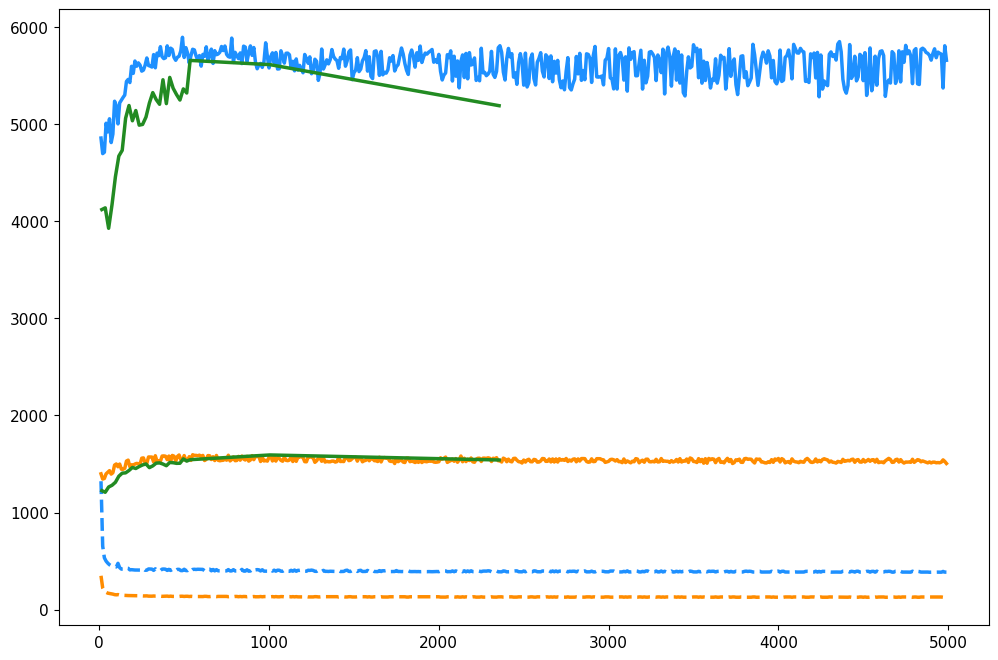

In [26]:
plt.plot(list(range(10, 5000, 10)), umap_training_mses, linewidth=2.5, color='darkorange', linestyle='dashed')
plt.plot(list(range(10, 5000, 10)), umap_test_mses, linewidth=2.5, color='darkorange', linestyle='solid')
plt.plot(list(range(10, 5000, 10)), umap_training_chi2s, linewidth=2.5, color='dodgerblue', linestyle='dashed')
plt.plot(list(range(10, 5000, 10)), umap_test_chi2s, linewidth=2.5, color='dodgerblue', linestyle='solid')
plt.plot(val_mses[0], val_mses[1], linewidth=2.5, color='forestgreen', linestyle='solid', label = 'UMAP NN')
plt.plot(val_chi2s[0], val_chi2s[1], linewidth=2.5, color='forestgreen', linestyle='solid', label = 'UMAP NN')

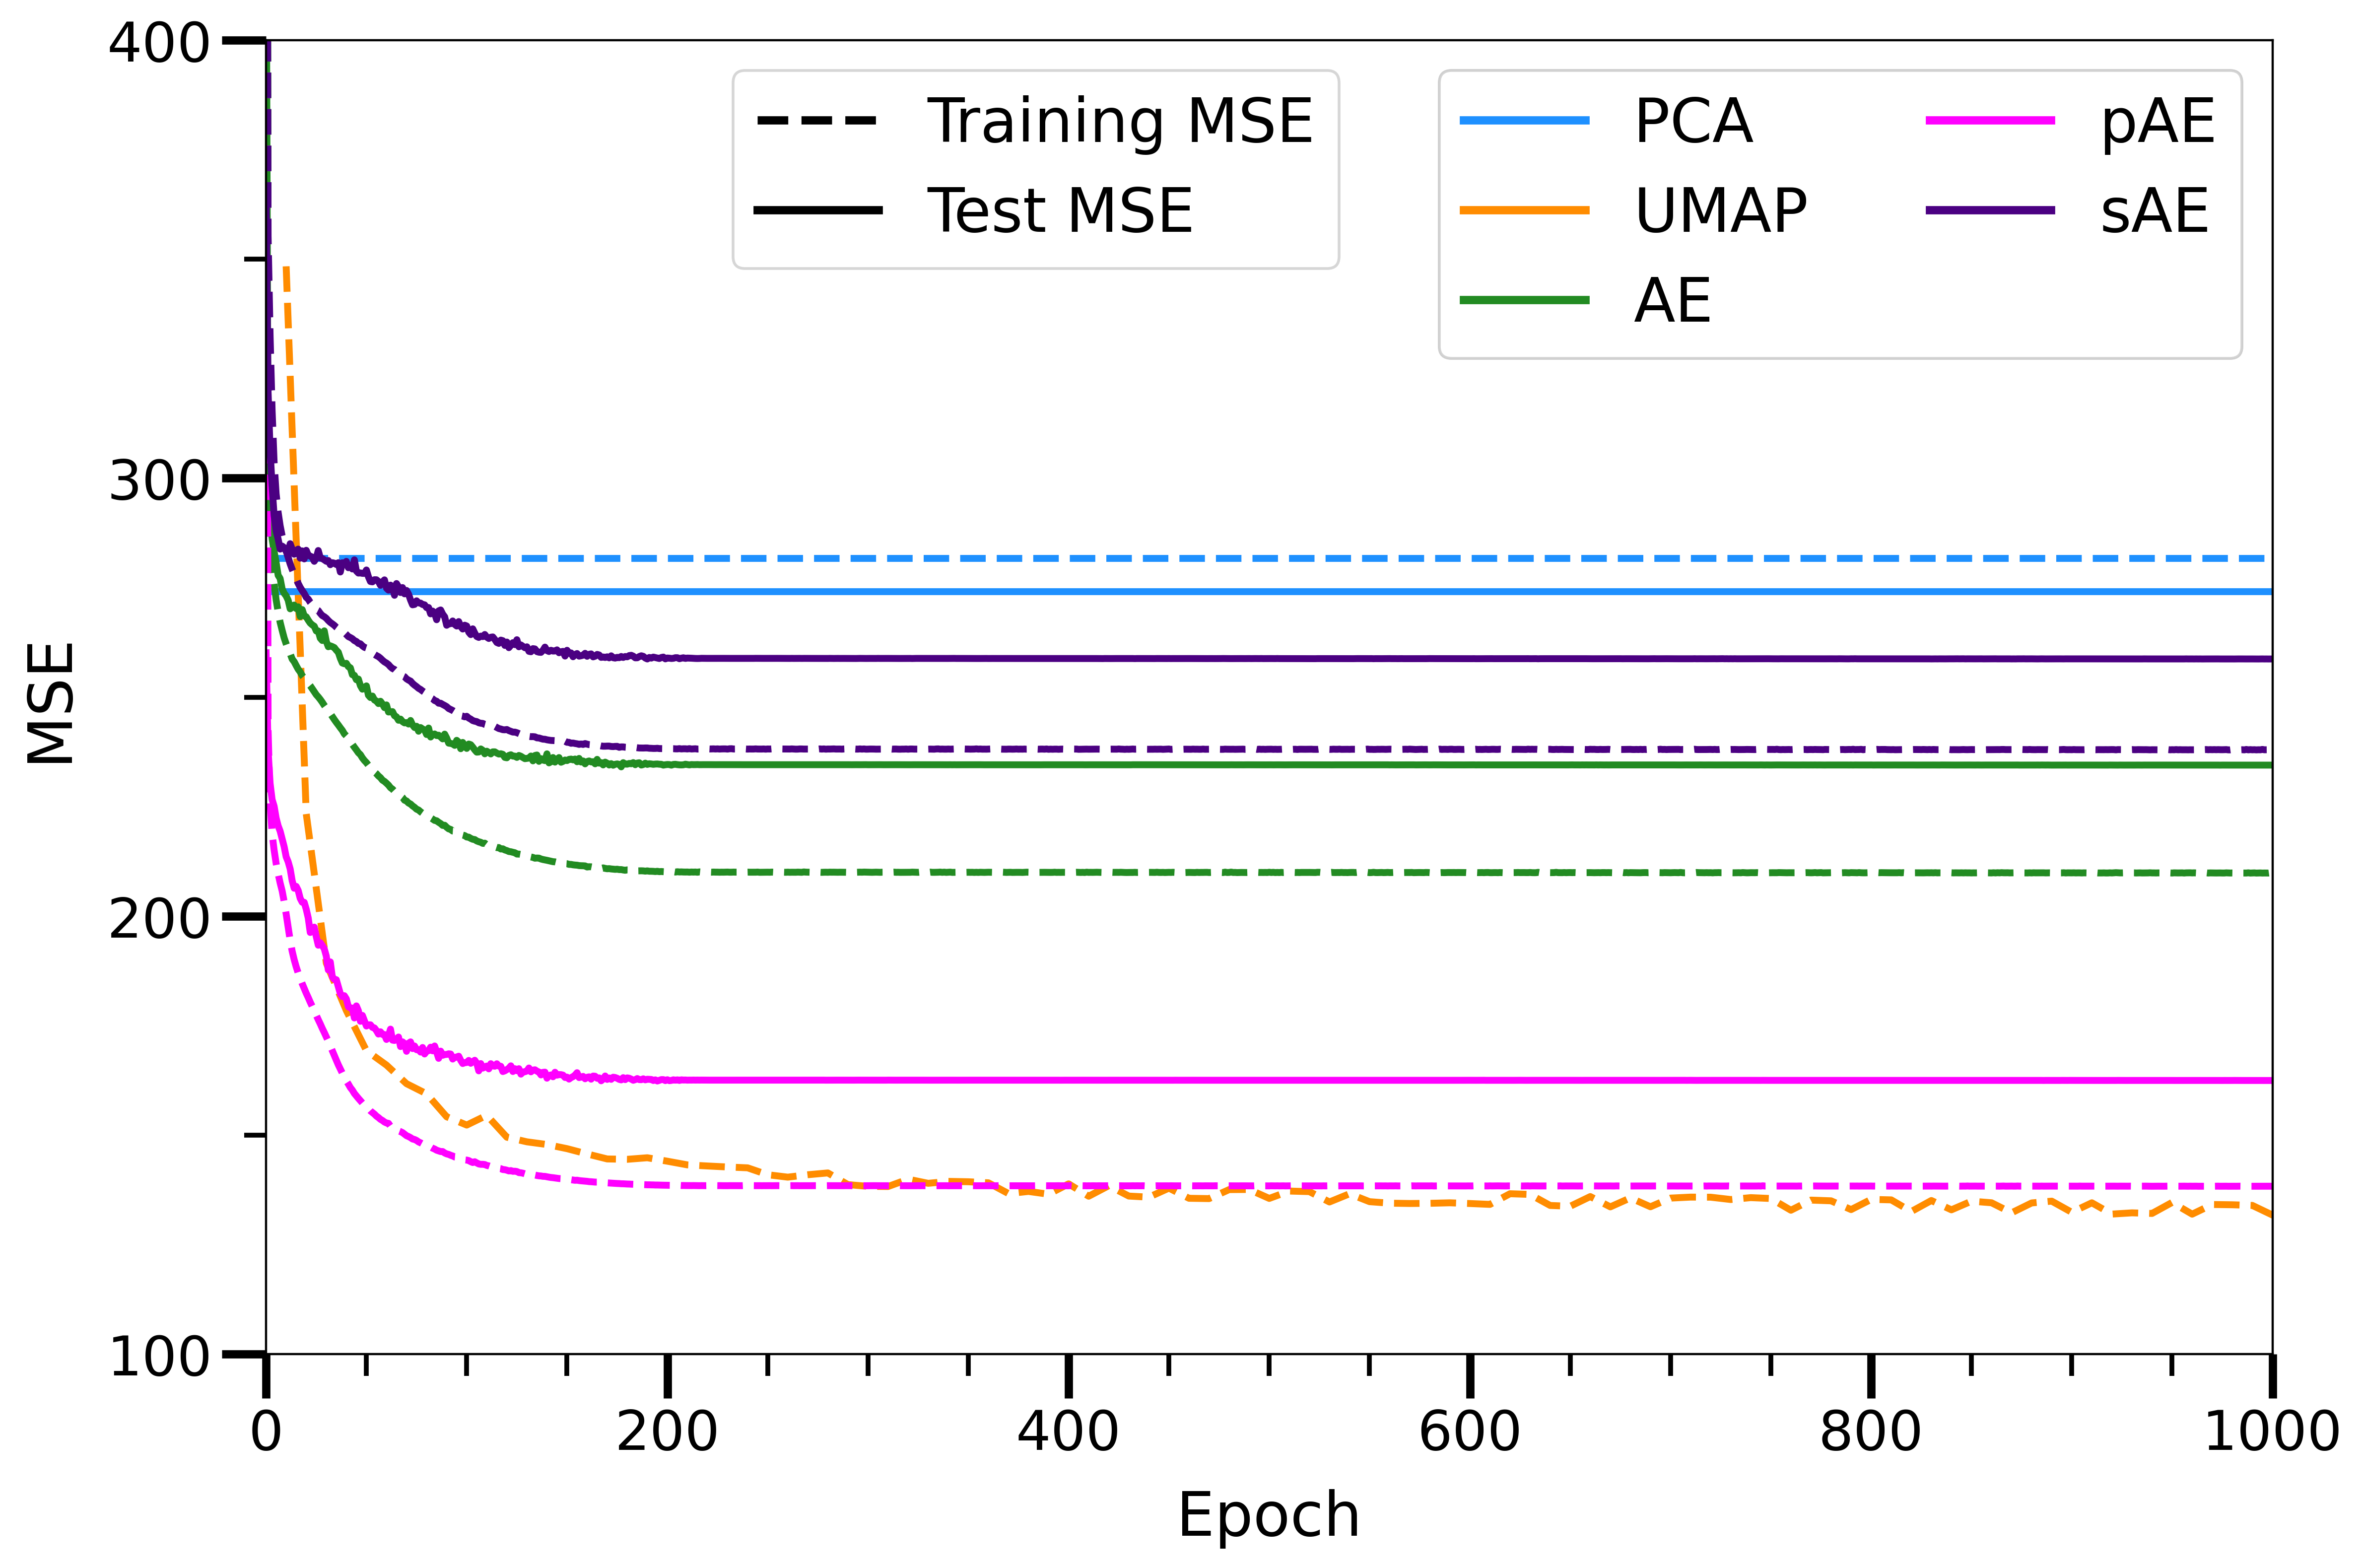

In [27]:
colors = ['dodgerblue', 'darkorange', 'forestgreen', 'fuchsia', 'indigo', 'brown', 'gold']
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(1, 1, figsize = (12, 8), dpi=400)
# plot PCA MSE
plt.axhline(pca_training_mse, linewidth=2.5, color='dodgerblue', linestyle='dashed')
plt.axhline(pca_test_mse, linewidth=2.5, color='dodgerblue', linestyle='solid')
# plot UMAP MSE
plt.plot(list(range(10, 5000, 10)), umap_training_mses, linewidth=2.5, color='darkorange', linestyle='dashed')
plt.plot(list(range(10, 5000, 10)), umap_test_mses, linewidth=2.5, color='darkorange', linestyle='solid')
# vanilla AE MSE
plt.plot(vanilla_history['mse'], linewidth=2.5, color='forestgreen', linestyle='dashed')
plt.plot(vanilla_history['val_mse'], linewidth=2.5, color='forestgreen', linestyle='solid')
# probabilistic AE MSE
plt.plot(prob_history['mse'], linewidth=2.5, color='fuchsia', linestyle='dashed')
plt.plot(prob_history['val_mse'], linewidth=2.5, color='fuchsia', linestyle='solid')
# scatter AE MSE
plt.plot(scatter_history['mse'], linewidth=2.5, color='indigo', linestyle='dashed')
plt.plot(scatter_history['val_mse'], linewidth=2.5, color='indigo', linestyle='solid')
# dummy lines
# test/train
dl1, = plt.plot([], [], c='black', linestyle='solid', linewidth=3.)
dl2, = plt.plot([], [], c='black', linestyle='dashed', linewidth=3.)
# PCA, UMAP, vanilla AE, pAE, sAE
dl3, = plt.plot([], [], c='dodgerblue', linestyle='solid', linewidth=3.)
dl4, = plt.plot([], [], c='darkorange', linestyle='solid', linewidth=3.)
dl5, = plt.plot([], [], c='forestgreen', linestyle='solid', linewidth=3.)
dl6, = plt.plot([], [], c='fuchsia', linestyle='solid', linewidth=3.)
dl7, = plt.plot([], [], c='indigo', linestyle='solid', linewidth=3.)
# scale
# plt.yscale('log')
# plt.xscale('log')
# tick params
plt.tick_params('both', length=16, width=3., which='major', labelsize=20)
plt.tick_params('both', length=8, width=1.75, which='minor', labelsize=20)
# x axis
ax.xaxis.set_major_locator(MultipleLocator(200.))
ax.xaxis.set_minor_locator(MultipleLocator(50.))
# y axis
ax.yaxis.set_major_locator(MultipleLocator(100.))
ax.yaxis.set_minor_locator(MultipleLocator(50.))
# limit, label
plt.xlim(0, 1000.)
plt.ylim(100., 400.)
plt.xlabel('Epoch', fontsize=22, labelpad=10)
plt.ylabel('MSE', fontsize=22, labelpad=10)
# legend
l1 = plt.legend([dl2, dl1], 
                ['Training MSE', 'Test MSE'],
                # loc = 'upper center',
                bbox_to_anchor=(0.55, 1.), loc='upper right', 
                fontsize=22, 
                ncol=1)
l2 = plt.legend([dl3, dl4, dl5, dl6, dl7], 
                [r'PCA', r'UMAP', r'AE', r'pAE', r'sAE'], 
                bbox_to_anchor=(1., 1.), loc='upper right',
                # loc = 'upper right',
                fontsize=22, 
                ncol=2)
ax.add_artist(l2)
ax.add_artist(l1)
# tight layout, save
plt.tight_layout()
plt.savefig('./paper_figures/mse_vs_epoch.png')

### Weighted MSE/chi2:

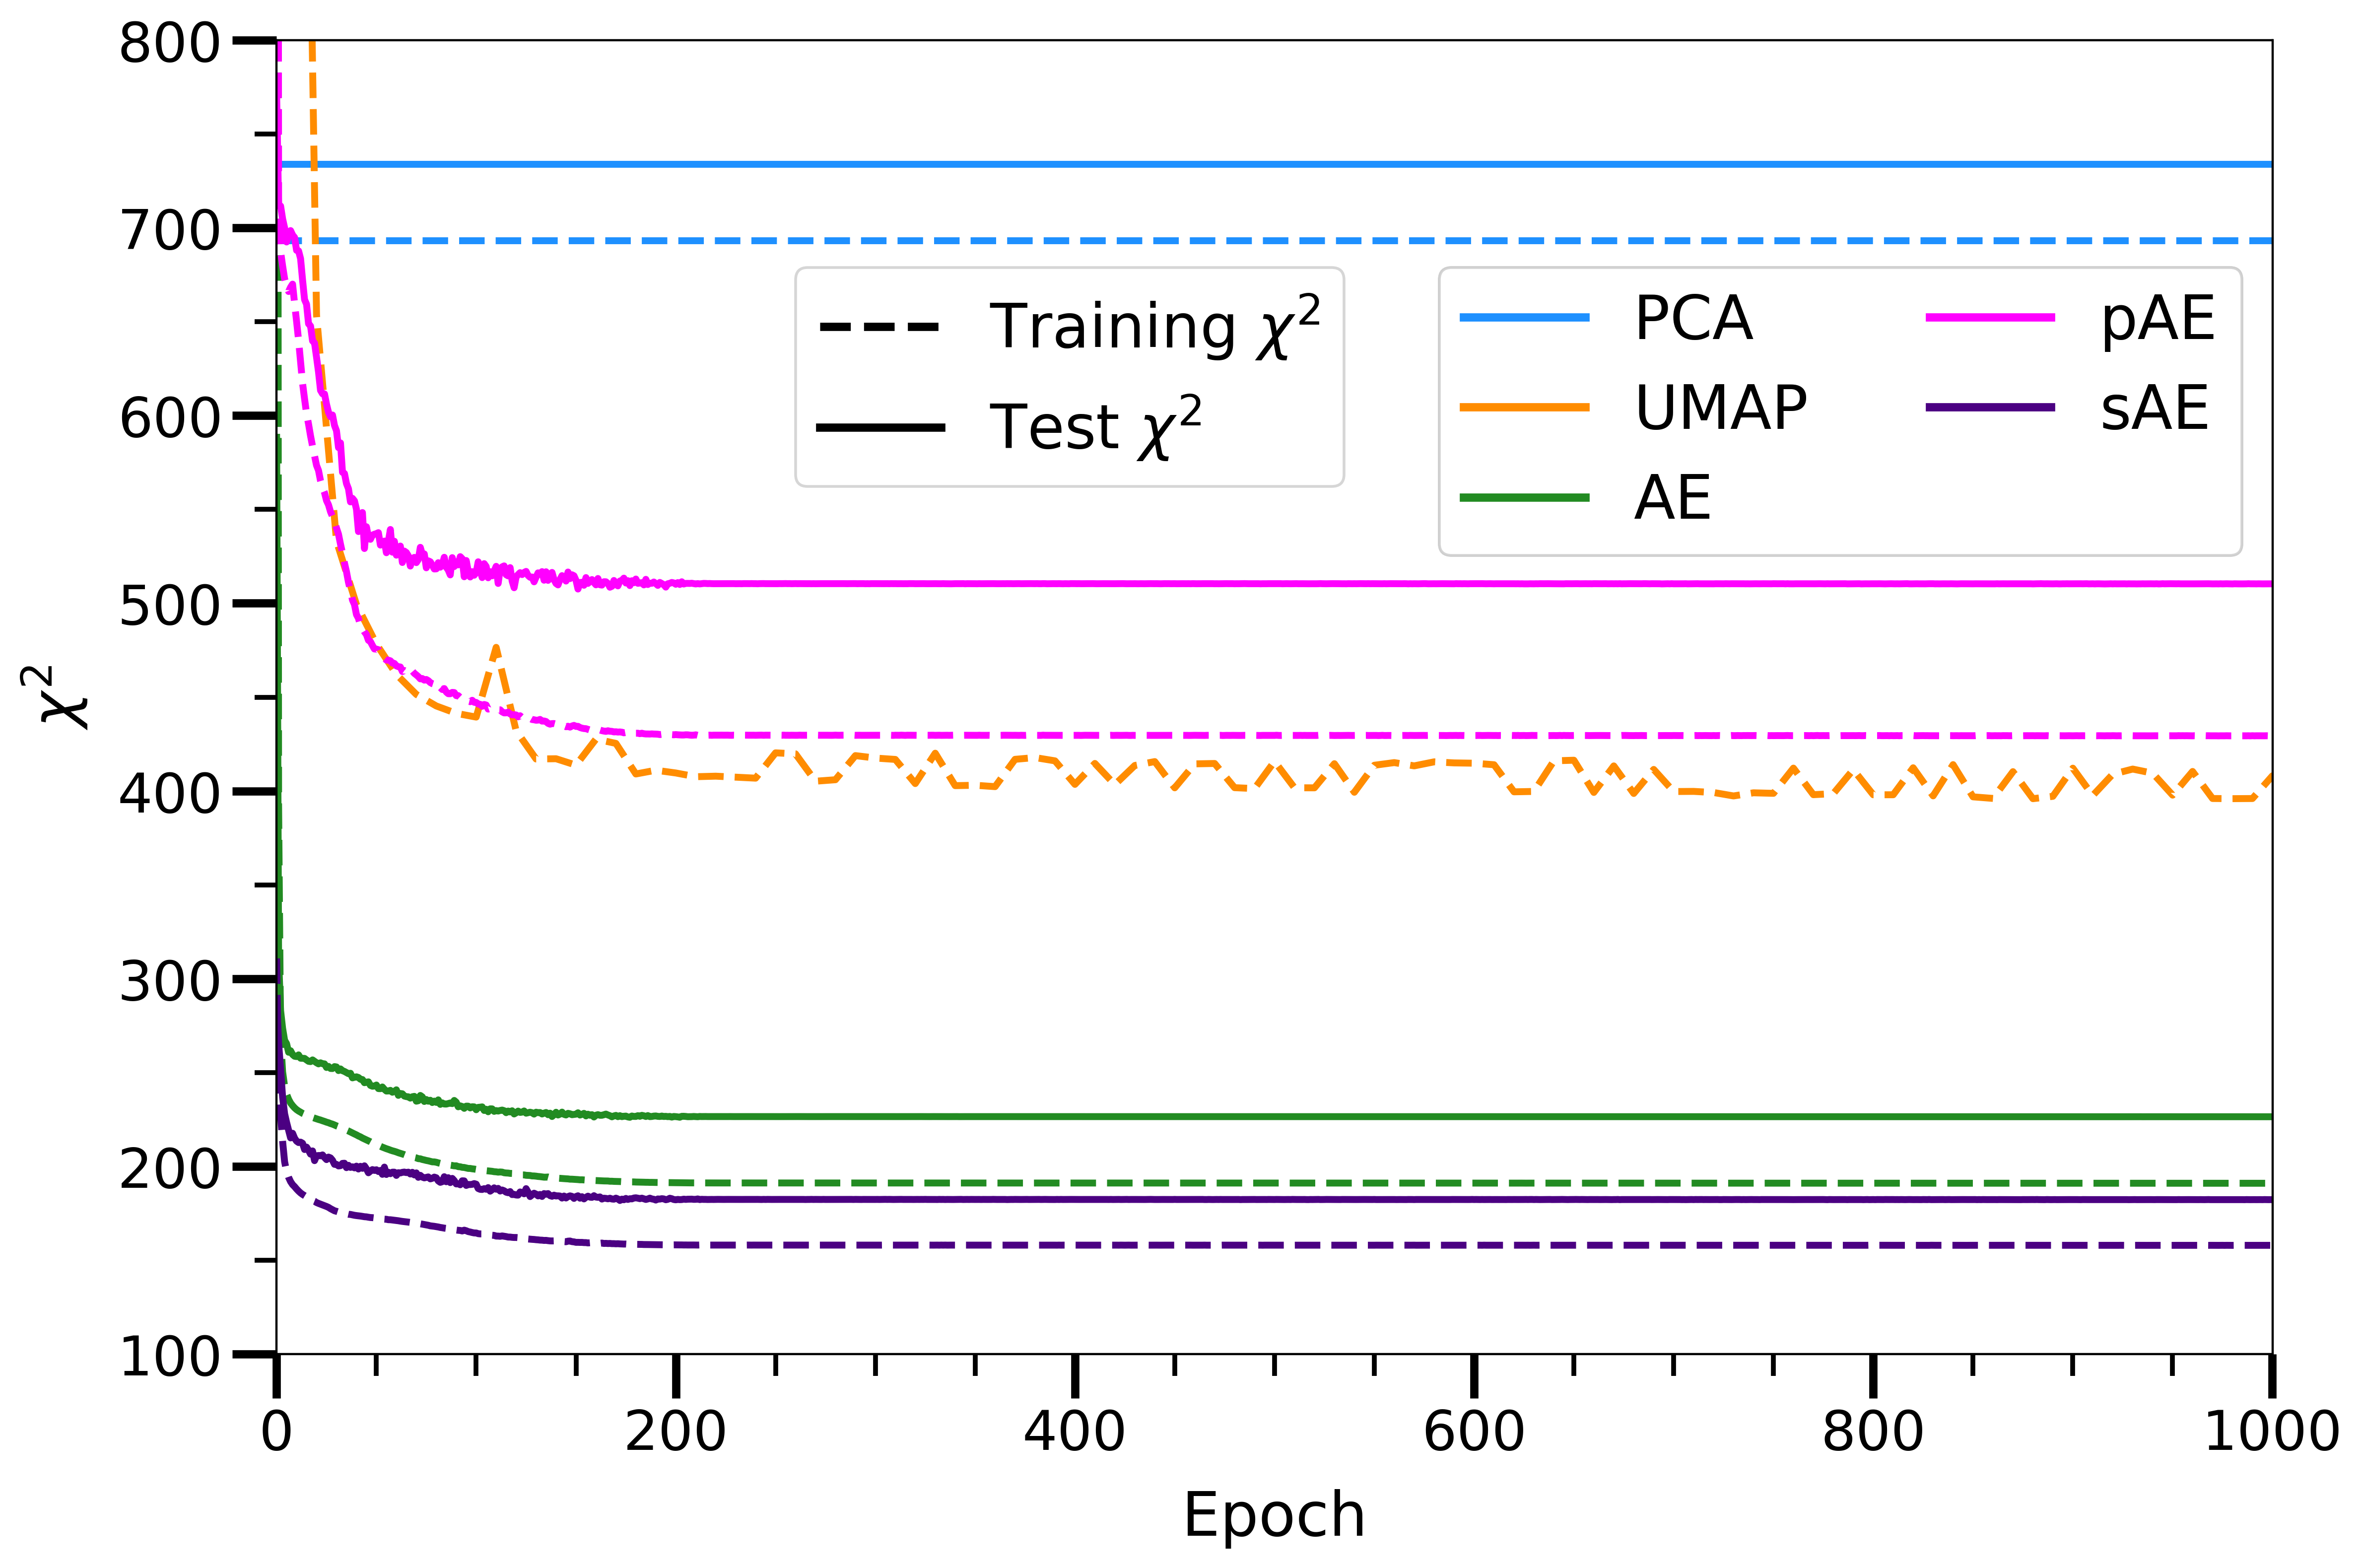

In [28]:
colors = ['dodgerblue', 'darkorange', 'forestgreen', 'fuchsia', 'indigo', 'brown', 'gold']
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(1, 1, figsize = (12, 8), dpi=400)
# plot PCA MSE
plt.axhline(pca_training_chi2, linewidth=2.5, color='dodgerblue', linestyle='dashed')
plt.axhline(pca_test_chi2, linewidth=2.5, color='dodgerblue', linestyle='solid')
# UMAP chi2
plt.plot(list(range(10, 5000, 10)), umap_training_chi2s, linewidth=2.5, color='darkorange', linestyle='dashed')
plt.plot(list(range(10, 5000, 10)), umap_test_chi2s, linewidth=2.5, color='darkorange', linestyle='solid')
# vanilla AE MSE
plt.plot(vanilla_history['chi2_loss'], linewidth=2.5, color='forestgreen', linestyle='dashed')
plt.plot(vanilla_history['val_chi2_loss'], linewidth=2.5, color='forestgreen', linestyle='solid')
# probabilistic AE MSE
plt.plot(prob_history['chi2_loss'], linewidth=2.5, color='fuchsia', linestyle='dashed')
plt.plot(prob_history['val_chi2_loss'], linewidth=2.5, color='fuchsia', linestyle='solid')
# scatter AE MSE
plt.plot(np.array(scatter_history['scatter_chi2_loss']) * 1000., linewidth=2.5, color='indigo', linestyle='dashed')
plt.plot(np.array(scatter_history['val_scatter_chi2_loss']) * 1000., linewidth=2.5, color='indigo', linestyle='solid')
# dummy lines
# test/train
dl1, = plt.plot([], [], c='black', linestyle='solid', linewidth=3.)
dl2, = plt.plot([], [], c='black', linestyle='dashed', linewidth=3.)
# PCA, UMAP, vanilla AE, pAE, sAE
dl3, = plt.plot([], [], c='dodgerblue', linestyle='solid', linewidth=3.)
dl4, = plt.plot([], [], c='darkorange', linestyle='solid', linewidth=3.)
dl5, = plt.plot([], [], c='forestgreen', linestyle='solid', linewidth=3.)
dl6, = plt.plot([], [], c='fuchsia', linestyle='solid', linewidth=3.)
dl7, = plt.plot([], [], c='indigo', linestyle='solid', linewidth=3.)
# scale
# plt.yscale('log')
# plt.xscale('log')
# tick params
plt.tick_params('both', length=16, width=3., which='major', labelsize=20)
plt.tick_params('both', length=8, width=1.75, which='minor', labelsize=20)
# x axis
ax.xaxis.set_major_locator(MultipleLocator(200.))
ax.xaxis.set_minor_locator(MultipleLocator(50.))
# y axis
ax.yaxis.set_major_locator(MultipleLocator(100.))
ax.yaxis.set_minor_locator(MultipleLocator(50.))
# limit, label
plt.xlim(0, 1000.)
plt.ylim(100., 800.)
plt.xlabel('Epoch', fontsize=22, labelpad=10)
plt.ylabel(r'$\chi^2$', fontsize=22, labelpad=10)
# legend
l1 = plt.legend([dl2, dl1], 
                [r'Training $\chi^2$', r'Test $\chi^2$'],
                # loc = 'upper center',
                bbox_to_anchor=(0.55, 0.85), loc='upper right', 
                fontsize=22, 
                ncol=1)
l2 = plt.legend([dl3, dl4, dl5, dl6, dl7], 
                [r'PCA', r'UMAP', r'AE', r'pAE', r'sAE'], 
                bbox_to_anchor=(1., 0.85), loc='upper right',
                # loc = 'upper right',
                fontsize=22, 
                ncol=2)
ax.add_artist(l2)
ax.add_artist(l1)
# tight layout, save
plt.tight_layout()
plt.savefig('./paper_figures/chi2_vs_epoch.png')